## Simple Energy Reconstruction Study Using CMSSW HGCAL MC Particle Guns

We will need the following additonal packages. 
To install these, issue: 
```bash
$ pip install uproot3 awkward0 tqdm ipywidgets scipy
```

In [245]:
import matplotlib.pyplot as plt
import uproot3 as uproot
import awkward as ak
import numpy as np
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm # adds progress bar 

### Particle Gun Simulations 

Particle Gun Simulations are among one of the most simple tools in detector high energy physics (HEP). In the context of the CMS experiment, they can aid in the assessment of detector parameters and geometry. Here, we'll use $e^{\pm}$ guns to help asses the performance of the electromagnetic compartment of the HGCAL, which is the end-cap particle calorimeters for the CMS detector. Currently, the detector geometry-- such as the number of layers, the thickness of layers, the front-end silicon wafer configurations, and various detector parameters-- are updated continuously and made available to the HEP community via CMSSW releases. These releases, which fall under the CMSSW software framework, is a command-line application that can perform simulations as well as calibrations and other tasks in HEP.    

In [81]:
def plot_ntuple(file_path:str, energy:str, evt_num:int):
    '''
    Generate two panel plots for one event given an ntuple file path. 
    '''
    ntuple = uproot.open(file_path)
    tree = ntuple['ana/hgc']
    fig = plt.figure(figsize=(15,12))
    fig.suptitle(r"Detector Hits for a Single Back-to-Back $e^{\pm}$ Event" + " at {} GeV".format(energy), 
                 y = .73, 
                 size = 14)
    # Note, it is easier to visualize (x, y, z) --> (z, x, y) 
    for panel in range (121,123):
        ax = fig.add_subplot(panel, projection='3d')
        ax.scatter(tree['simhit_z'].array()[evt_num], 
                   tree['simhit_x'].array()[evt_num], 
                   tree['simhit_y'].array()[evt_num],
                   label = "simulated",
                   color = "tab:red", 
                   alpha = 1,
                   s = .50)
        mask = np.in1d(tree['rechit_z'].array()[evt_num], tree['simhit_z'].array()[evt_num], invert = True) 
        ax.scatter(tree['rechit_z'].array()[evt_num][mask], 
                   tree['rechit_x'].array()[evt_num][mask], 
                   tree['rechit_y'].array()[evt_num][mask],
                   label = "reconstructed",
                   color = "tab:blue",
                   alpha = .75,
                   s = .55)
        ax.plot([-320., 320.], [0,0], [0,0], color='k', label = "beam line") 
        ax.set_xlabel('Detector Coord z')
        ax.set_ylabel('Detector Coord x')
        ax.set_zlabel('Detector Coord y')
        if panel == 121: 
            ax.set_proj_type('ortho')
        else: 
            ax.view_init(15, 25)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc=(.45, .71))

To help visualize what this study is about, we'll first explore what one single $\it{event}$ looks like. Here, we are using back-to-back single particle gun simulations. Back-to-back just means that electron-positron pairs are shot at both of the end-caps at a random energy distribution centered at some value, which in this case we will choose to be 20 TeV. Each event is one electron and positron simultaneously shot back-to-back (the positron goes to one endcap and the electron gets deposited at the other) at the calorimeter. 

Note we have plotted one sample event for two distinct particle-gun energies of 20 GeV and 1 TeV; though, we will only analyze 20 GeV. CMSSW is able to simulate how the particle propagates through the calorimeter. The red points count as a simulated hit and the blue is the reconstructed hit. It is important to note that each electron sent into the detector not only has a random energy, but also random angles with respect to the beam axis, which is the line in the plots. Each generated shower, when deposited into the calorimeter, decays into constituent daughter particles which are then the constituents of the simulated hit. This simulated hit contains the information about the initial particle and the cascade of daughter particles it generated. This simulated hit is part of the larger data set called the reconstructed hit. The reconstructed hit contains the simulated hit plus detector noise. So, essentially, the red is the signal, and the blue dots are the noise. The noise comes from the detector parameters such as the silicon wafers' electronics readout noise (though, it is important to note that the detector is cooled so as to minimize external noise).   

Each measurement the detector makes is not perfectly resolved; not only does the detector see the initial particles and the cascade resulting from it, it also sees random hits (derived from CMSSW detector properties). The higher the energy, the higher the number of particles deposited into the calorimeter; hence, the higher the signal-to-noise ratio (SNR). This can be seen by looking at the relatively low number of blue dots in the 1 TeV event in comparison to the 20 GeV event. 


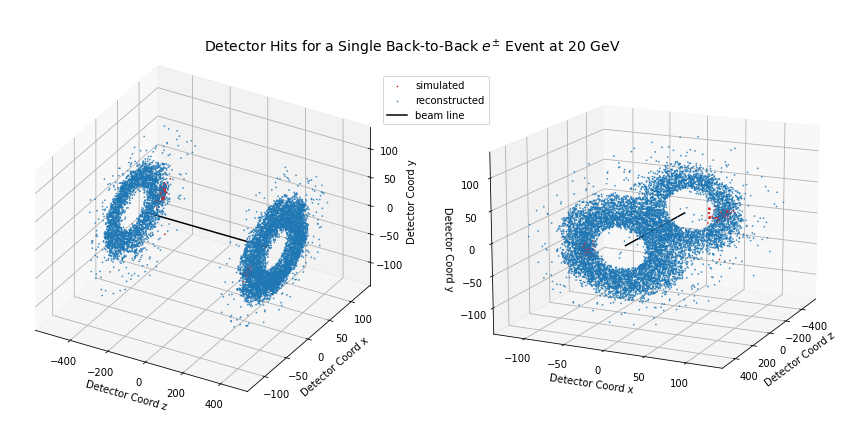

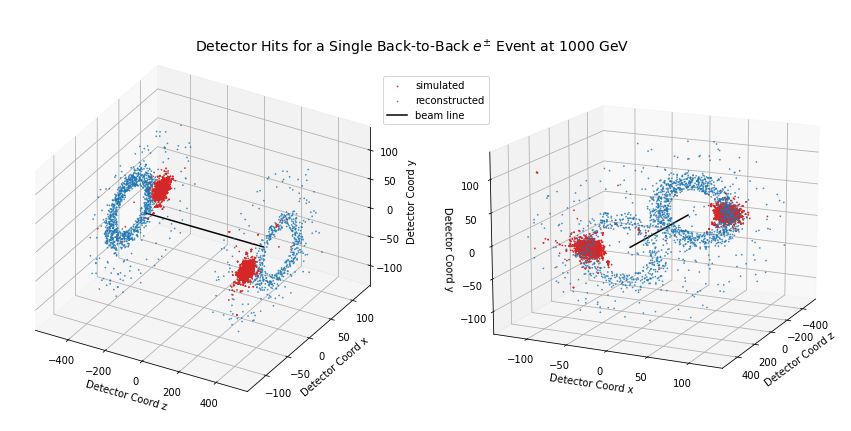

In [82]:
plot_ntuple('../hgcalNtuple_20.root', '20', 100)
plot_ntuple('../hgcalNtuple_1000_1.root', '1000', 100)

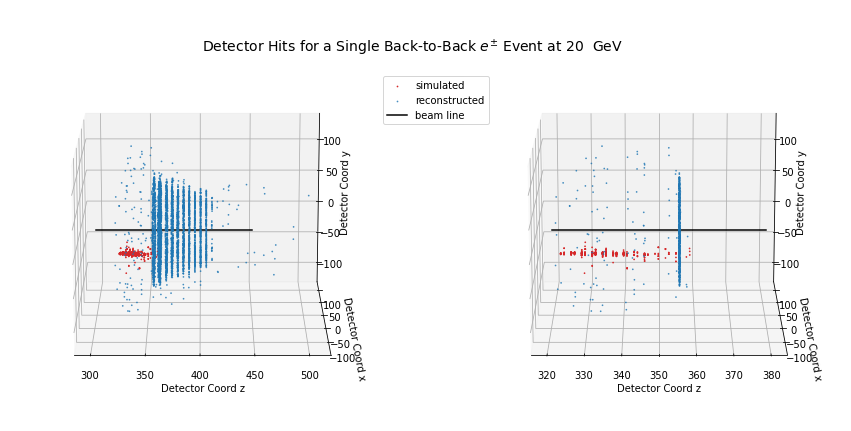

In [83]:
ntuple = uproot.open('../hgcalNtuple_20.root')
tree = ntuple['ana/hgc']
evt_num = 10
fig = plt.figure(figsize=(15,12))

fig.suptitle(r"Detector Hits for a Single Back-to-Back $e^{\pm}$ Event at 20  GeV", 
             y = .73, 
             size = 14)
# Note, it is easier to visualize (x, y, z) --> (z, x, y) 
ax = fig.add_subplot(121, projection='3d')
endcap_mask = tree['simhit_z'].array()[evt_num]> 0
ax.scatter(tree['simhit_z'].array()[evt_num][endcap_mask], 
           tree['simhit_x'].array()[evt_num][endcap_mask], 
           tree['simhit_y'].array()[evt_num][endcap_mask],
           label = "simulated",
           color = "tab:red", 
           alpha = 1,
           s = .50)
mask = np.in1d(tree['rechit_z'].array()[evt_num], tree['simhit_z'].array()[evt_num], invert = True) 
endcap_mask = tree['rechit_z'].array()[evt_num][mask] > 0
ax.scatter(tree['rechit_z'].array()[evt_num][mask][endcap_mask], 
           tree['rechit_x'].array()[evt_num][mask][endcap_mask], 
           tree['rechit_y'].array()[evt_num][mask][endcap_mask],
           label = "reconstructed",
           color = "tab:blue",
           alpha = .75,
           s = .55)
ax.plot([300, 450], [0,0], [0,0], color='k', label = "beam line")
ax.set_xlabel('Detector Coord z')
ax.set_ylabel('Detector Coord x')
ax.set_zlabel('Detector Coord y')
ax.view_init(15, -90)

# Note, it is easier to visualize (x, y, z) --> (z, x, y) 
ax = fig.add_subplot(122, projection='3d')
endcap_mask = tree['simhit_z'].array()[evt_num]> 0
ax.scatter(tree['simhit_z'].array()[evt_num][endcap_mask], 
           tree['simhit_x'].array()[evt_num][endcap_mask], 
           tree['simhit_y'].array()[evt_num][endcap_mask],
           label = "simulated",
           color = "tab:red", 
           alpha = 1,
           s = .50)
mask = np.in1d(tree['rechit_z'].array()[evt_num], tree['simhit_z'].array()[evt_num], invert = True) 
endcap_mask = tree['rechit_z'].array()[evt_num][mask] > 0
layer_mask = tree['rechit_layer'].array()[evt_num][mask][endcap_mask] < 27
ax.scatter(tree['rechit_z'].array()[evt_num][mask][endcap_mask][layer_mask], 
           tree['rechit_x'].array()[evt_num][mask][endcap_mask][layer_mask], 
           tree['rechit_y'].array()[evt_num][mask][endcap_mask][layer_mask],
           label = "reconstructed",
           color = "tab:blue",
           alpha = .75,
           s = .55)
ax.plot([320, 380], [0,0], [0,0], color='k', label = "beam line")
ax.set_xlabel('Detector Coord z')
ax.set_ylabel('Detector Coord x')
ax.set_zlabel('Detector Coord y')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(.45, .71))
ax.view_init(15, -90)

### Detector Geometry

The image focuses on the positive z xis of the detectors. A common convention of describing detector coordinates is through the use of the $(\eta,\phi)$ (eta-phi) space. $\eta$ describes the longitudinal angle, with 0 being parallel to the y-axis and infininty parallel to the beam axis. $\phi$ described the angle with respect to the x axis. Refering back to the detector's geometry, you can see that there are layers to the calorimeter. Each ring constitutes a layer. Here, we will be focusing on layers < 27, where most of the EM compartment resides. This would be appropriate since were are dealing with electrons. Also, it filters some of the rechit noise from our data. Also, the electron energy deposition does not make it all the way through the layers of the detector, it is stopped within the EM compartment. The red hits shows the trajectory of the cascades of hits from one single $e^{\pm}$  event propagating from left to right.  

### Ntuples
The energies, the postion, the angles, and all other pertinent information about a simulation run is stored into an ntuple. Ntuples in the HEP context are highly structed data files storing (mostly asymmetric arrays) information about the generated particle energies, simulated events, the reconstructed events, and other detection and detector parameters. Here, we have generated each event. Each simulated event has its corresponding reconstructed event (what the detector reconstructs). You can picture the structure of the ntuple as a tree with each branch containing a desired simulated or reconstructed paramter; for example, the x coordinates of reconstructed hits (here, we have established hit as just one data point read by the detector). Extending the analogy, each event has a leaf in this branch. and each leaf is an n-vector containing the x-coordinates of each of the dots you see in the 3-d plots. The jagged arrays comes from the fact that the number of hits varies per event.       

In [179]:
ntuple = uproot.open('../hgcalNtuple_20.root')
tree = ntuple['ana/hgc']

event                      (no streamer)              asdtype('>u8')
lumi                       (no streamer)              asdtype('>u4')
run                        (no streamer)              asdtype('>u4')
vtx_x                      (no streamer)              asdtype('>f4')
vtx_y                      (no streamer)              asdtype('>f4')
vtx_z                      (no streamer)              asdtype('>f4')
genpart_eta                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_phi                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_pt                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_energy             TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvx                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvy                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvz                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpa

Run the cell below to see all the branches in the tree. 

In [ ]:
tree.show()

Below is the reconstruction algorithm which iterates through each event and corresponding reconstructed events. The alogrithm is teribly inefficient given large data sets. Reconstructing 1000 events takes ~ 1 hour. But it only has one master loop, the rest is of the filtering done by masking and vectorized numpy arithmetic. 

In [225]:
def reconstruct_rechit_energies(num_evts:int, delta_r=0.3, return_delta_r=False, z="pos"):
    """
    Main function of reconstructing the energies. 
    """
    reconstructed_energies = np.ones(num_evts)
    delta_rs = []
    for evt_num in tqdm(range (0,num_evts)):
        #endcap_mask = tree['simhit_z'].array()[evt_num] > 0
        rechit_layer = tree['rechit_layer'].array()[evt_num]
        rechit_z = np.array(tree['rechit_z'].array())[evt_num]
        # loop through each rechits for an event and makes boolean masks 
      
        if z == "pos":
            end_cap=(0,0)
            eta = end_cap[0]
            phi = end_cap[1]
            gen_eta = np.array(tree['gen_eta'].array())[evt_num][eta]
            gen_phi = np.array(tree['gen_phi'].array())[evt_num][phi]
            # 27 focuses on EM
            layer_and_z_mask = (rechit_z > 0) & (rechit_layer < 27)
        elif z == "neg": 
            end_cap=(1,1)
            eta = end_cap[0]
            phi = end_cap[1]
            gen_eta = np.array(tree['gen_eta'].array())[evt_num][eta]
            gen_phi = np.array(tree['gen_phi'].array())[evt_num][phi]
            layer_and_z_mask = (rechit_z < 0) & (rechit_layer < 27)
        else:
            print("enter valid endcap")

        # masks the rechit eta and phi to our desired endcap and layer
        rechit_eta = np.array(tree['rechit_eta'].array())[evt_num][layer_and_z_mask] 
        rechit_phi = np.array(tree['rechit_phi'].array())[evt_num][layer_and_z_mask]

        # compares distance between generated angles and rechit angles 
        distances = np.sqrt((gen_eta-rechit_eta)**2 + (gen_phi-rechit_phi)**2) 

        # if the angle is close enough (0.3), we can count that energy as part of the simulated hit 
        distance_thresh_mask = distances < delta_r

        # save the distances that made the cut
        delta_rs.append(distances[distance_thresh_mask]) 

        # get the rechit energies associated with the event. 
        reco_energies = np.array(tree['rechit_energy'].array())[evt_num][layer_and_z_mask][distance_thresh_mask]

        # sum it to get the energy for one event (which we expect to be 20 GeV)
        reconstructed_energies[evt_num] = reco_energies.sum()
        
    if  return_delta_r is False:
        return reconstructed_energies 
    else: 
        return reconstructed_energies, delta_rs

In [226]:
rechits = reconstruct_rechit_energies(num_evts=200, delta_r=0.3, return_delta_r=False, z="neg")

  0%|          | 0/200 [00:00<?, ?it/s]

Save the reconstructed energies into a file. 

In [227]:
np.savetxt('recohit_e_20_gev_200evts_neg_endcap.txt', rechits)

The the delta_rs contain the angular distances of each hit from the generated particle angles. Each event has a different number of hits ad therefore different number of hits meet this threshold per event, so we have a jagged list. One straight forward way to deal with this is to take each event and just combine them into one vector-- the event distinction is erased. 

In [211]:
flat_delta_rs = np.array([item for sublist in delta_rs for item in sublist])
print(flat_delta_rs.size)
np.savetxt('flat_delta_rs_neg_endcap.txt', flat_delta_rs )

692126


To preserve the event-by-event basis, we can loop through each jagged list and pad them to equal lengths. 

In [201]:
symmetric_dela_rs_array = np.zeros([2000,1800])
for idx, vec in enumerate(delta_rs): 
    vec = np.array(vec)
    # extend the array to a length of 2000 after checking that max is ~1500
    # padded with 0s
    vec.resize(1800)
    symmetric_dela_rs_array[idx,:] = vec
# we can re-pad it with nan for smaller file sizes
symmetric_dela_rs_array  = np.round_(symmetric_dela_rs_array,4).astype('float32') 
symmetric_dela_rs_array[symmetric_dela_rs_array == 0] = np.nan
np.savetxt('delta_rs.txt', symmetric_dela_rs_array)

We'll analyze the reconstructed energy for the positve z endcap.

In [249]:
def freedman_diaconis (parameter): 
    """
    Returns appropriate equal-width bins based on Freedman–Diaconis rule 
    en.wikipedia.org/wiki/Freedman–Diaconis_rule
    """
    #print(parameter.size)
    q75, q25 = np.percentile(parameter, [75 ,25])
    iqr = q75 - q25
    binwidth = (2*iqr) / ( parameter.size**(1/3) ) 
    bins = round( (float(max(parameter) - float (min(parameter)) ) / binwidth ) )
    return int(bins)

def gaussian(x, mu, sigma, norm):
    """
    Gaussian distribution
    """
    return norm * np.exp(-((x-mu)/sigma)**2/2) / sigma/np.sqrt(2*np.pi)

In [290]:
bins = 15

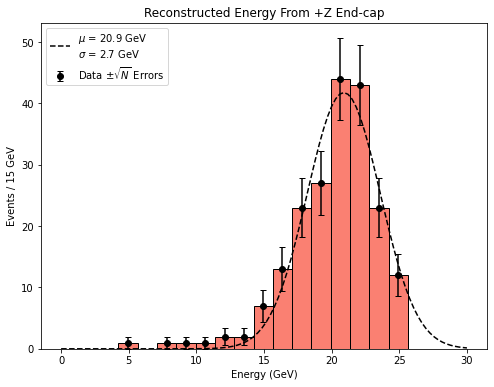

In [301]:
energies = np.genfromtxt('./recohit_e_20_gev_500evts.txt')[:200]
freq, bin_edges = np.histogram(energies, bins=bins ) 

# mask zero valued frequency
mask = ~(freq == 0 )  
bin_ctr = 0.5*(bin_edges[1:] + bin_edges[:-1])

params, pcov = curve_fit(gaussian, bin_ctr[mask], freq[mask])

theory_x = np.linspace(0,30,100)
theory_curve = gaussian(theory_x, *params)

fig = plt.figure(figsize=(8,6))
plt.errorbar(bin_ctr[mask],
             freq[mask],
             yerr = np.sqrt(freq)[mask],
             fmt ='o',
             capsize= 3,
             label = r'Data $ \pm \sqrt{N}$ Errors', 
             color="black")
plt.hist(energies, 
         bins=bins , 
         edgecolor='black', 
         color="salmon") 
plt.plot(theory_x , 
         theory_curve, 
         '--k', 
         label="$\mu$ = {:.1f} GeV \n$\sigma$ = {:.1f} GeV ".format(*params[0:2]) )

plt.title('Reconstructed Energy From +Z End-cap')
plt.xlabel('Energy (GeV)')
plt.ylabel('Events / {:.0f} GeV'.format(bins))
plt.legend()
plt.show()

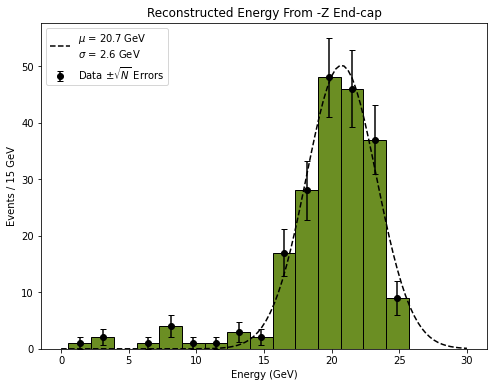

In [302]:
energies = np.genfromtxt('./recohit_e_20_gev_200evts_neg_endcap.txt')
freq, bin_edges = np.histogram(energies, bins=bins ) 

# mask zero valued frequency
mask = ~(freq == 0 )  
bin_ctr = 0.5*(bin_edges[1:] + bin_edges[:-1])

params, pcov = curve_fit(gaussian, bin_ctr[mask], freq[mask])

theory_x = np.linspace(0,30,100)
theory_curve = gaussian(theory_x, *params)

fig = plt.figure(figsize=(8,6))
plt.errorbar(bin_ctr[mask],
             freq[mask],
             yerr = np.sqrt(freq)[mask],
             fmt ='o',
             capsize= 3,
             label = r'Data $ \pm \sqrt{N}$ Errors', 
             color="black")
plt.hist(energies, 
         bins=bins , 
         edgecolor='black', 
         color="olivedrab") 
plt.plot(theory_x , 
         theory_curve, 
         '--k',         
         label="$\mu$ = {:.1f} GeV \n$\sigma$ = {:.1f} GeV ".format(*params[0:2]) )

plt.title('Reconstructed Energy From -Z End-cap')
plt.xlabel('Energy (GeV)')
plt.ylabel('Events / {:.0f} GeV'.format(bins))
plt.legend()
plt.show()

Fred Angelo B. Garcia, Fall 2021